# 6.1 F8_LinearKalmanFilter
模块功能：求解卡尔曼滤波最优估计值

In [1]:
import numpy as np

def F8_LinearKalmanFilter(A, B, Q_c, R_c, H, z, x_hat, P, u):

    # 计算先验状态估计
    x_hat_minus = A @ x_hat + B @ u
    # 计算先验估计误差协方差矩阵
    P_minus = A @ P @ A.T + Q_c
    # 计算卡尔曼增益
    K = P_minus @ H.T @ np.linalg.pinv(H @ P_minus @ H.T + R_c)
    # 更新后验估计
    x_hat = x_hat_minus + K @ (z - H @ x_hat_minus)
    # 后验估计误差协方差矩阵
    P = (np.eye(A.shape[0]) - K @ H) @ P_minus
    
    return x_hat, x_hat_minus, P

# 6.2 KalmanFilter_UAV_ConstantInput
程序功能：线性卡尔曼滤波器案例

In [2]:
from scipy.signal import cont2discrete

# 系统参数定义
m = 1.0  # 无人机质量
g = 10.0  # 重力加速度常数

# 系统矩阵构建
A = np.array([[0., 1., 0.],
              [0., 0., 1.],
              [0., 0., 0.]])
n = A.shape[0]  # A矩阵维度
B = np.array([[0.],
              [1. / m],
              [0.]])
p = B.shape[1]  # B矩阵维度

H_m = np.eye(n)  # 定义测量矩阵H_m, n x n

# 系统离散化
Ts = 0.1  # 离散时间步长
sys_d = cont2discrete((A, B, np.zeros((n, 1)), np.zeros((1, 1))), Ts)
A = sys_d[0]
B = sys_d[1]

# 参数设计
Q_c = np.array([[0.01, 0., 0.], 
                [0., 0.01, 0.], 
                [0., 0., 0.]])  # 定义过程噪声协方差矩阵
R_c = np.array([[1., 0., 0.], 
                [0., 1., 0.], 
                [0., 0., 0.]])  # 定义测量噪声协方差矩阵

In [3]:
# 系统初始化
x0 = np.array([[0.], 
               [1.], 
               [-10.]])  # 初始化系统状态
x = x0
u0 = np.array([[g]])  # 系统输入初始化
u = u0
x_hat0 = np.array([[0.], 
                   [1.], 
                   [-10.]])  # 初始化后验估计
x_hat = x_hat0
P0 = np.array([[1., 0., 0.], 
                [0., 1., 0.], 
                [0., 0., 0.]])  # 初始化后验估计误差协方差矩阵
P = P0

In [4]:
# 定义系统运行步数
k_steps = 100
x_history = np.zeros((n, k_steps + 1))  # 定义x_history零矩阵
u_history = np.zeros((p, k_steps))  # 定义u_history零矩阵
x_hat_history = np.zeros((n, k_steps + 1))  # 定义x_hat_history零矩阵
x_hat_minus_history = np.zeros((n, k_steps + 1))  # 定义x_hat_minus_history零矩阵
z_history = np.zeros((n, k_steps + 1))  # 定义z_history零矩阵

x_history[:, 0] = x.flatten()
x_hat_history[:, 0] = x_hat.flatten()
x_hat_minus_history[:, 0] = x_hat.flatten()
z_history[:, 0] = x_hat.flatten()

In [5]:
# 定义仿真环境
w = np.zeros((n, k_steps))  # 定义过程噪声矩阵W
v = np.zeros((n, k_steps))  # 定义测量噪声矩阵V
# 读取数据，这里使用numpy的loadtxt函数代替MATLAB的csvread
w = np.loadtxt('NoiseData_w.csv', delimiter=',', skiprows=1)[0:3, :]
v = np.loadtxt('NoiseData_v.csv', delimiter=',', skiprows=1)[0:3, :]

In [6]:
for k in range(k_steps):
    x = A @ x + B @ u + w[:, k].reshape((-1, 1))  # 系统状态空间方程，计算实际状态变量
    z = H_m @ x + v[:, k].reshape((-1, 1))        # 计算实际测量值
    
    # 使用卡尔曼滤波器
    x_hat, x_hat_minus, P = F8_LinearKalmanFilter(A, B, Q_c, R_c, H_m, z, x_hat, P, u)
    
    # 保存数据到历史记录中
    x_history[:, k+1] = x.flatten()
    z_history[:, k+1] = z.flatten()
    x_hat_minus_history[:, k+1] = x_hat_minus.flatten()
    x_hat_history[:, k+1] = x_hat.flatten()

In [7]:
import matplotlib.pyplot as plt

%matplotlib inline

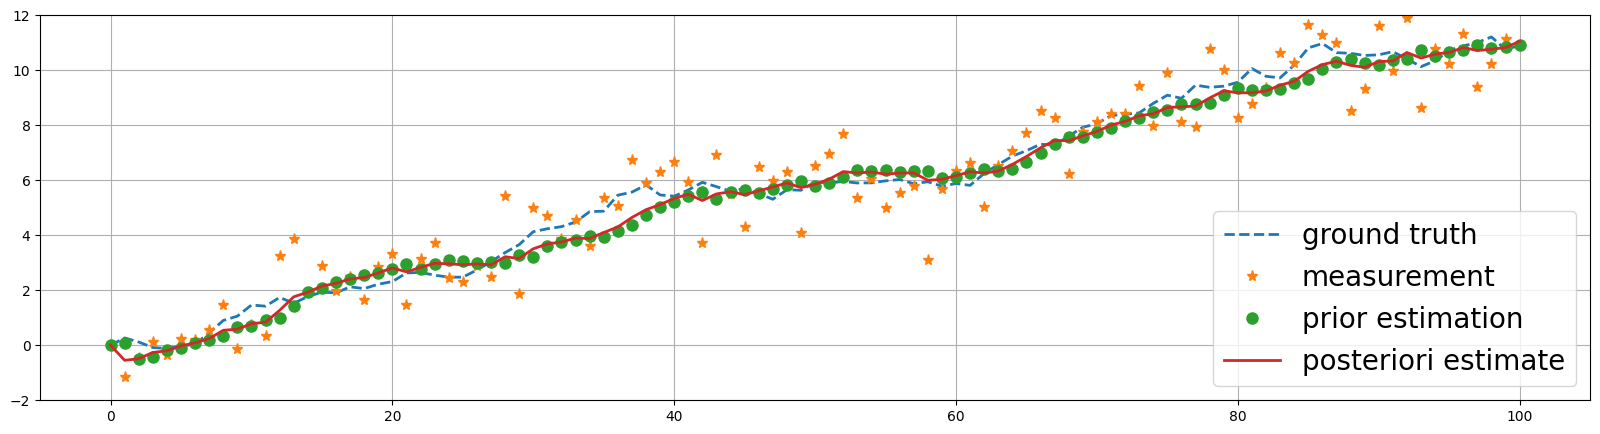

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(x_history[0, :], '--', linewidth=2, label='ground truth')
plt.plot(z_history[0, :], '*', markersize=8, label='measurement')
plt.plot(x_hat_minus_history[0, :], 'o', markersize=8, label='prior estimation')
plt.plot(x_hat_history[0, :], linewidth=2, label='posteriori estimate')
plt.legend(loc='lower right', fontsize=20)
plt.ylim([-2, 12])
plt.grid(True)
plt.show()

In [9]:
# 计算Ems 均方误差
Ems = np.sum((x_hat_history[0, :] - x_history[0, :])**2) / k_steps
Ems

0.18349519584260635

# 6.3 KalmanFilter_MPC_UAV
程序功能：无人机高度速度模型预测控制与卡尔曼滤波器结合示例

In [10]:
# 系统参数定义
m = 1.0  # 无人机质量
g = 10.0  # 重力加速度常数

# 系统矩阵构建
A = np.array([[0., 1., 0.],
              [0., 0., 1.],
              [0., 0., 0.]])
n = A.shape[0]  # A矩阵维度
B = np.array([[0.],
              [1. / m],
              [0.]])
p = B.shape[1]  # B矩阵维度

H_m = np.eye(n)  # 定义测量矩阵H_m, n x n

# 系统离散化
Ts = 0.1  # 离散时间步长
sys_d = cont2discrete((A, B, np.zeros((n, 1)), np.zeros((1, 1))), Ts)
A = sys_d[0]
B = sys_d[1]

In [11]:
# 权重设计
Q = np.diag([1., 1., 0.])
S = np.diag([1., 1., 0.])
R = np.array([[0.1]])

In [12]:
# 系统参考值
xd = np.array([[10.],
               [0.],
               [-g]])
AD = np.eye(n)
ud, _, _, _ = np.linalg.lstsq(B, (np.eye(n) - A) @ xd, rcond=None)

In [13]:
# 卡尔曼参数设计
# 定义过程噪声协方差矩阵
Q_c = np.diag([0.01, 0.01, 0.])
# 定义测量噪声协方差矩阵
R_c = np.diag([1., 1., 0.])

In [14]:
# 系统初始化
x0 = np.array([[0.], 
               [1.], 
               [-10.]])  # 初始化系统状态
x = x0
xa = np.vstack([x, xd])
x_hat0 = np.array([[0.], 
                   [1.], 
                   [-10.]])  # 初始化后验估计
x_hat = x_hat0
P0 = np.array([[1., 0., 0.], 
                [0., 1., 0.], 
                [0., 0., 0.]])  # 初始化后验估计误差协方差矩阵
P = P0

In [15]:
# 定义系统约束
u_low = np.array([-3.])
u_high = np.array([2.])
x_low = np.array([[0.], 
                  [-4.], 
                  [-g]])
x_high = np.array([[12.], 
                   [5.], 
                   [-g]])
xa_low = np.vstack((x_low, -np.inf * np.ones((n, 1))))
xa_high = np.vstack((x_high, np.inf * np.ones((n, 1))))

In [16]:
from scipy.linalg import block_diag, toeplitz

def F2_InputAugmentMatrix_SS_U(A, B, Q, R, S, xd):
    n = A.shape[1]
    p = B.shape[1]

    Ca = np.block([np.eye(n), -np.eye(n)])
    Aa = np.block([
        [A, np.eye(n) - A],
        [np.zeros((n, n)), np.eye(n)]
    ])
    Ba = np.block([
        [B],
        [np.zeros((n, p))]
    ])
    Qa = Ca.T @ Q @ Ca

    Sa = Ca.T @ S @ Ca

    ud, _, _, _ = np.linalg.lstsq(B, (np.eye(n) - A) @ xd, rcond=None)  # ud = np.linalg.pinv(B) @ ((np.eye(n) - A) @ xd)

    return Aa, Ba, Qa, Sa, R, ud


def F4_MPC_Matrices_PM(A, B, Q, R, S, N_P):
    n = A.shape[0]
    p = B.shape[1]

    Phi = np.zeros((N_P*n, n))
    Gamma = np.zeros((N_P*n, N_P*p))

    for i in range(N_P):
        Phi[i*n:(i+1)*n, :] = np.linalg.matrix_power(A, i+1)
        for j in range(i + 1): 
            Gamma[i*n:(i+1)*n, j*p:(j+1)*p] = np.linalg.matrix_power(A, i - j) @ B

    Omega = np.kron(np.eye(N_P-1), Q)
    Omega = block_diag(Omega, S)

    Psi = np.kron(np.eye(N_P), R)

    F = Gamma.T @ Omega @ Phi
    H = Psi + Gamma.T @ Omega @ Gamma

    return Phi, Gamma, Omega, Psi, F, H

def F6_MPC_Matrices_Constraints(x_low, x_high, u_low, u_high, N_P, Phi, Gamma):

    n = x_low.shape[0]
    p = u_low.shape[0]

    M = np.vstack([np.zeros((p, n)), 
                   np.zeros((p, n)), 
                   -np.eye(n), 
                   np.eye(n)])
    
    F = np.vstack([-np.eye(p), 
                   np.eye(p), 
                   np.zeros((n, p)), 
                   np.zeros((n, p))])
    
    Beta = np.vstack([-u_low, 
                      u_high, 
                      -x_low, 
                      x_high])
    
    M_Np = np.vstack([-np.eye(n), 
                      np.eye(n)])
    
    Beta_N = np.vstack([-x_low, 
                        x_high])

    
    M_bar = np.zeros(((2*n+2*p)*N_P+2*n, n))
    M_bar[:(2*n+2*p), :] = M

    
    Beta_bar = np.tile(Beta, (N_P, 1))
    Beta_bar = np.vstack([Beta_bar, Beta_N])

    M_2bar = M
    F_2bar = F
    for i in range(1, N_P-1):
        M_2bar = np.block([[M_2bar, np.zeros((M_2bar.shape[0], M.shape[1]))], 
                           [np.zeros((M.shape[0], M_2bar.shape[1])), M]])
        F_2bar = np.block([[F_2bar, np.zeros((F_2bar.shape[0], F.shape[1]))], 
                           [np.zeros((F.shape[0], F_2bar.shape[1])), F]])

    M_2bar = np.block([
        [np.zeros((2*n+2*p, n*N_P))],
        [M_2bar, np.zeros((M_2bar.shape[0], n))],
        [np.zeros((M_Np.shape[0], M_2bar.shape[1])), M_Np]
    ])
    F_2bar = np.block([[F_2bar, np.zeros((F_2bar.shape[0], F.shape[1]))], 
                           [np.zeros((F.shape[0], F_2bar.shape[1])), F]])
    F_2bar = np.block([[F_2bar], 
                       [np.zeros((2*n, p*N_P))]])

    b = -(M_bar + np.dot(M_2bar, Phi))
    
    M = np.dot(M_2bar, Gamma) + F_2bar
    
    return M, Beta_bar, b
    
N_P = 20
Aa, Ba, Qa, Sa, R, ud = F2_InputAugmentMatrix_SS_U(A, B, Q, R, S, xd)
Phi, Gamma, Omega, Psi, F, H = F4_MPC_Matrices_PM(Aa, Ba, Qa, R, Sa, N_P)
M, Beta_bar, b = F6_MPC_Matrices_Constraints(xa_low, xa_high, u_low, u_high, N_P, Phi, Gamma)

In [17]:
# 定义仿真环境
w = np.zeros((n, k_steps))  # 定义过程噪声矩阵W
v = np.zeros((n, k_steps))  # 定义测量噪声矩阵V
# 读取数据，这里使用numpy的loadtxt函数代替MATLAB的csvread
w = np.loadtxt('NoiseData_w.csv', delimiter=',', skiprows=1)[0:3, :]
v = np.loadtxt('NoiseData_v.csv', delimiter=',', skiprows=1)[0:3, :]

In [18]:
k_steps = 100
x_history = np.zeros((n, k_steps+1))
u_history = np.zeros((p, k_steps))
x_hat_history = np.zeros((n, k_steps+1))
x_hat_minus_history = np.zeros((n, k_steps+1))
z_history = np.zeros((n, k_steps+1))

x_history[:, 0] = x.flatten()
x_hat_history[:, 0] = x_hat.flatten()
x_hat_minus_history[:, 0] = x_hat.flatten()
z_history[:, 0] = x_hat.flatten()

In [19]:
import numpy as np
from qpsolvers import solve_qp

def F7_MPC_Controller_withConstriants(x, F, H, M, Beta_bar, b, p):

    P = H
    q = F @ x
    G = M
    h = Beta_bar + b @ x

    # 解二次规划
    U = solve_qp(P, q, G, h, solver="quadprog")
    # 选择控制序列的第一组元素
    u = U[:p]
    return U, u

In [20]:
for k in range(k_steps):
    delta_U, delta_u = F7_MPC_Controller_withConstriants(xa, F, H, M, Beta_bar, b, p)
    u = delta_u + ud
    x = A @ x + B @ u + w[:, k].reshape((-1, 1))
    z = H_m @ x + v[:, k].reshape((-1, 1))        # 计算实际测量值

    # 使用卡尔曼滤波器
    x_hat, x_hat_minus, P = F8_LinearKalmanFilter(A, B, Q_c, R_c, H_m, z, x_hat, P, u)
    
    xa = np.vstack([x, xd])
    x_history[:, k+1] = x.flatten()
    u_history[:, k] = u.flatten()
    z_history[:, k+1] = z.flatten()
    x_hat_minus_history[:, k+1] = x_hat_minus.flatten()
    x_hat_history[:, k+1] = x_hat.flatten()

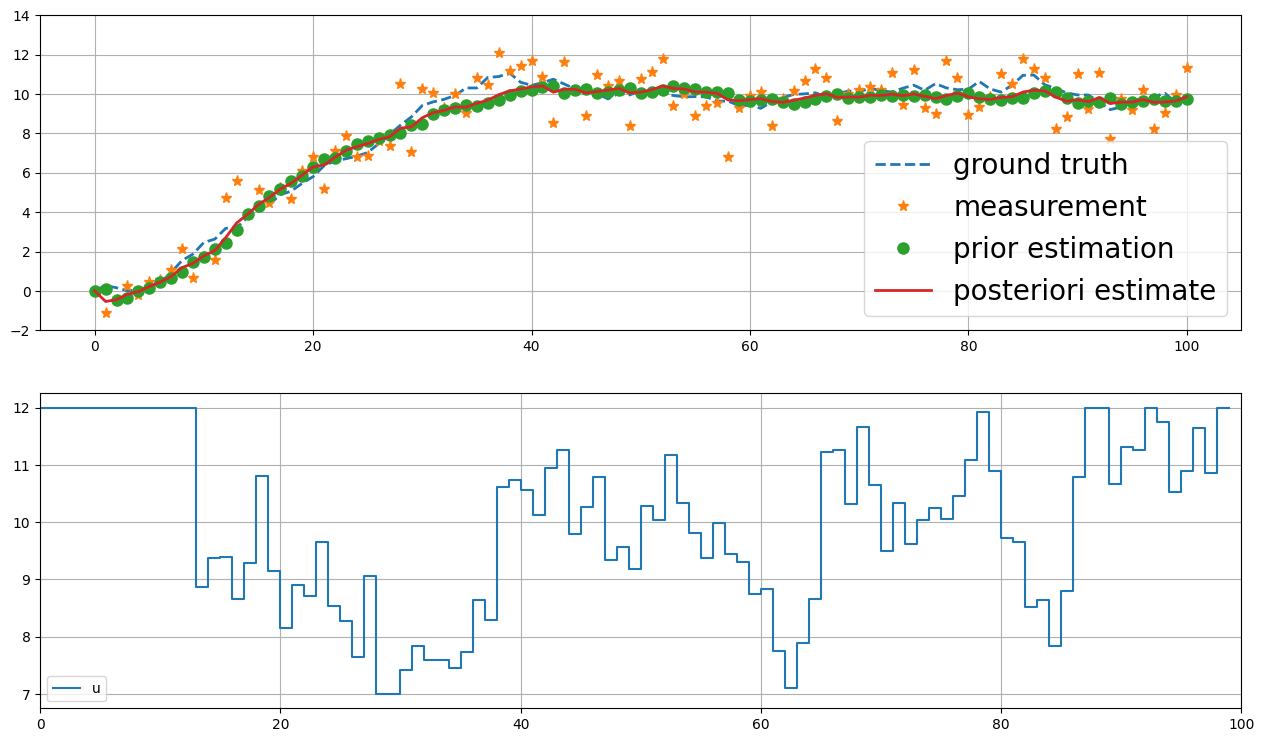

In [21]:
plt.figure(figsize=(15.5, 9))
plt.subplot(2, 1, 1)
plt.plot(x_history[0], '--', linewidth=2, label='ground truth')
plt.plot(z_history[0], '*', markersize=8, label='measurement')
plt.plot(x_hat_minus_history[0], 'o', markersize=8, label='prior estimation')
plt.plot(x_hat_history[0], linewidth=2, label='posteriori estimate')
plt.ylim([-2, 14])
plt.grid(True)
plt.legend(loc='lower right', fontsize=20)

plt.subplot(2, 1, 2)
plt.step(range(k_steps), u_history[0], label='u')
plt.legend()
plt.grid(True)
plt.xlim([0, k_steps])
plt.show()

# 6.4 Extended_KalmanFilter
程序功能：扩展卡尔曼滤波器案例

In [22]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设计
# 离散时间步长
Ts = 0.01

# 过程噪声协方差矩阵
Q = np.array([[0.01, 0.], 
              [0., 0.01]])
# 测量噪声协方差矩阵
R_c = np.array([[0.1, 0.], 
                [0., 0.1]])

# 重力加速度
g = 10.
# 连杆长度
l = 0.5

# 系统初始化
x0 = np.array([np.pi/4., 0.])
x = x0.copy()

x_hat0 = x0.copy()
x_hat = x_hat0.copy()

z = np.array([0., 0.])
x_hat_minus = np.array([0., 0.])

P0 = np.eye(2)
P = P0.copy()

# 计算变量维度
n = len(x)

In [23]:
# 定义系统运行步数
k_steps = 200

# 定义历史记录零矩阵
x_history = np.zeros((n, k_steps))
x_hat_history = np.zeros((n, k_steps))
x_hat_minus_history = np.zeros((n, k_steps))
z_history = np.zeros((n, k_steps))

# 过程与测量噪声真实协方差矩阵
Q_a = Q.copy()
R_a = R_c.copy()

# 随机生成过程噪声和测量噪声
w = np.random.multivariate_normal(np.zeros(n), Q_a, k_steps).T
v = np.random.multivariate_normal(np.zeros(n), R_a, k_steps).T

In [24]:
# Kalman Filter Implementation
for k in range(k_steps):
    # 系统状态空间方程
    x[0] += x[1] * Ts + w[0, k]
    x[1] += -g/l*np.sin(x[0]) * Ts + w[1, k]
    # 实际测量值
    z[0] = x[0] + v[0, k]
    z[1] = x[1] + v[1, k]

    # 扩展卡尔曼滤波器
    x_hat_minus[0] = x_hat[0] + x_hat[1] * Ts
    x_hat_minus[1] = x_hat[1] - g/l*np.sin(x_hat[0]) * Ts
    A = np.array([[1., Ts], 
                  [-g/l*np.cos(x_hat[0])*Ts, 1]])
    W = np.eye(n)
    H_m = np.eye(n)
    V = np.eye(n)
    
    # 先验估计误差协方差矩阵
    P_minus = A @ P @ A.T + W @ Q @ W.T
    
    # 卡尔曼增益
    K = P_minus @ H_m.T @ np.linalg.pinv(H_m @ P_minus @ H_m.T + V @ R_c @ V.T)
    
    # 后验估计
    x_hat = x_hat_minus + K @ (z - x_hat_minus)
    
    # 后验估计误差协方差矩阵
    P = (np.eye(n) - K @ H_m) @ P_minus
    
    # 更新历史记录
    x_history[:, k] = x
    z_history[:, k] = z
    x_hat_minus_history[:, k] = x_hat_minus
    x_hat_history[:, k] = x_hat

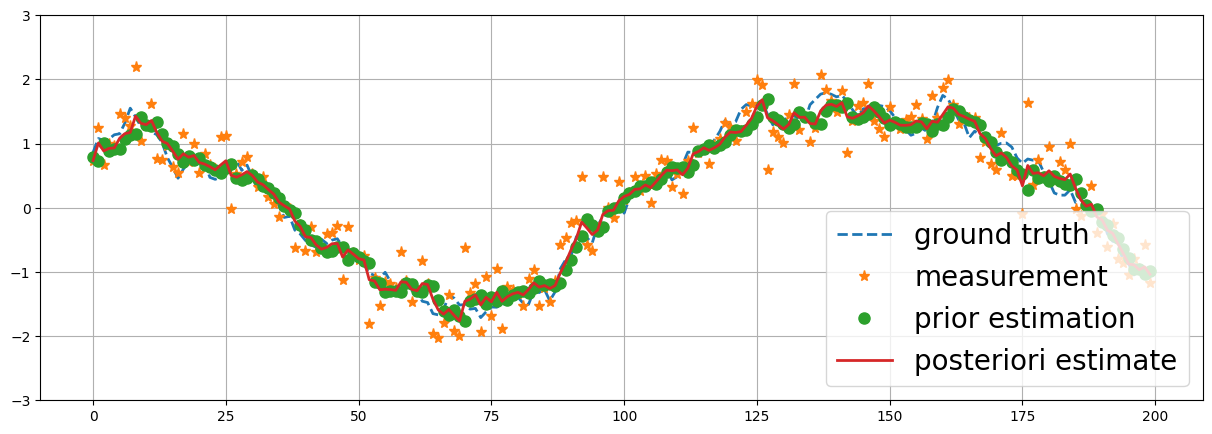

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(x_history[0], '--', linewidth=2, label='ground truth')
plt.plot(z_history[0], '*', markersize=8, label='measurement')
plt.plot(x_hat_minus_history[0], 'o', markersize=8, label='prior estimation')
plt.plot(x_hat_history[0], linewidth=2, label='posteriori estimate')
plt.ylim([-3, 3])
plt.legend(loc='lower right', fontsize=20)
plt.grid(True)
plt.show()

In [26]:
Ems = np.mean((x_hat_history[0] - x_history[0]) ** 2)
Ems

0.023093124997149533